In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /home/cvk/mmocr/
!ls

%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import math
import pytesseract
from PIL import Image, ImageEnhance
import numpy as np
import pdf2image
import cv2

1.7.0+cu110 True
2.18.0
1.3.17
11.0
GCC 7.3
0.3.0
/home/cvk/mmocr
 annot				 nanonets.png
 annotorious-openseadragon	 node_modules
 bounding_boxes.csv		 output_hocr.hocr
 box.png			 output_hocr.txt
 CITATION.cff			 outputs
 configs			 package-lock.json
 data				 README.md
 default10000.png		 README_zh-CN.md
 demo				 requirements
 docker				 requirements.txt
 docs				 resources
 docs_zh_CN			 result100.png
 east_coco.ipynb		 result100.txt
 edges-50-150.jpg		 result1.csv
 example1.pdf			 result.csv
 example2.pdf			 result.png
 example3.pdf			 setup.cfg
 example4.pdf			 setup.py
 example5.pdf			 TableOCR.ipynb
 example6.pdf			 TableOCR-Kmeans.ipynb
 example7.pdf			'TableWithGridLayoutOCR 1.01.ipynb'
 example.pdf			 temp.png
 Final_round_mmocr-Copy1.ipynb	 test1.csv
 Final_round_mmocr-Copy2.ipynb	 test5.csv
 Final_round_mmocr-Copy3.ipynb	 test6.csv
 Final_round_mmocr-Copy4.ipynb	 test7.csv
 Final_round_mmocr.ipynb	 test8.csv
 frozen_east_text_detection.pb	 test9.csv
 houghlines3.jpg		 tes

In [2]:
def convert_pdf_to_image(document, dpi):
    images = []
    images.extend(
                    list(
                        map(
                            lambda image: cv2.cvtColor(
                                np.asarray(image), code=cv2.COLOR_RGB2BGR
                            ),
                            pdf2image.convert_from_path(document, dpi=dpi),
                        )
                    )
                )
    return images

In [3]:
images = convert_pdf_to_image('example1.pdf',300)

In [4]:
print(len(images))

1


In [5]:
print(images[0].shape)

(3508, 2481, 3)


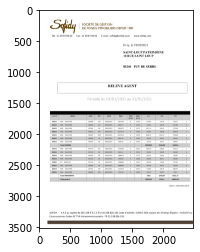

In [6]:
first_page = images[0]
cv2.imwrite('/home/cvk/mmocr/demo/img/demo02.png', first_page)
plt.imshow(first_page)


In [7]:
#parameters
lineFactor = 0.8

In [8]:
from mmocr.utils.ocr import MMOCR
import pytesseract
import cv2

img = 'demo/img/demo2.png'


mmocr = MMOCR(det='PS_CTW',kie = 'SDMGR')
#mmocr.readtext(img, print_result = False, output='demo/out004.png')
a = mmocr.readtext(img, details=True)

results = []
image = cv2.imread(img)

for element in a[0]['result']:
    x = 0
    y = 0
    xs = []
    ys = []
    for idx, i in enumerate(element['box']):
        if idx % 2 == 0:
            xs.append(i)
            x += i
        else:
            ys.append(i)
            y += i
            
    x = round(x / (len(element['box'])/2))
    y = round(y / (len(element['box'])/2))
    
    crop = image[min(ys):max(ys), min(xs):max(xs)]
    config = ("-l eng+fra --oem 3 --psm 13")
    text = pytesseract.image_to_string(crop, config=config)

    results.append({
        'x': x,
        'y': y,
        'text': text.replace('|',''),
        'xmin':min(xs),
        'xmax':max(xs),
        'ymin':min(ys),
        'ymax':max(ys),
        
    })



load checkpoint from http path: https://download.openmmlab.com/mmocr/textdet/psenet/psenet_r50_fpnf_600e_ctw1500_20210401-216fed50.pth


/home/cvk/mmocr/mmocr/apis/inference.py:48: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


load checkpoint from http path: https://download.openmmlab.com/mmocr/textrecog/seg/seg_r31_1by16_fpnocr_academic-72235b11.pth
load checkpoint from http path: https://download.openmmlab.com/mmocr/kie/sdmgr/sdmgr_unet16_60e_wildreceipt_20210520-7489e6de.pth


/home/cvk/.local/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/cvk/mmocr/mmocr/datasets/kie_dataset.py:43: UserWarning: KIEDataset is only initialized as a downstream demo task of text detection and recognition without an annotation file.
  warnings.warn(
/home/cvk/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/cvk/mmocr/mmocr/datasets/pipelines/box_utils.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, us

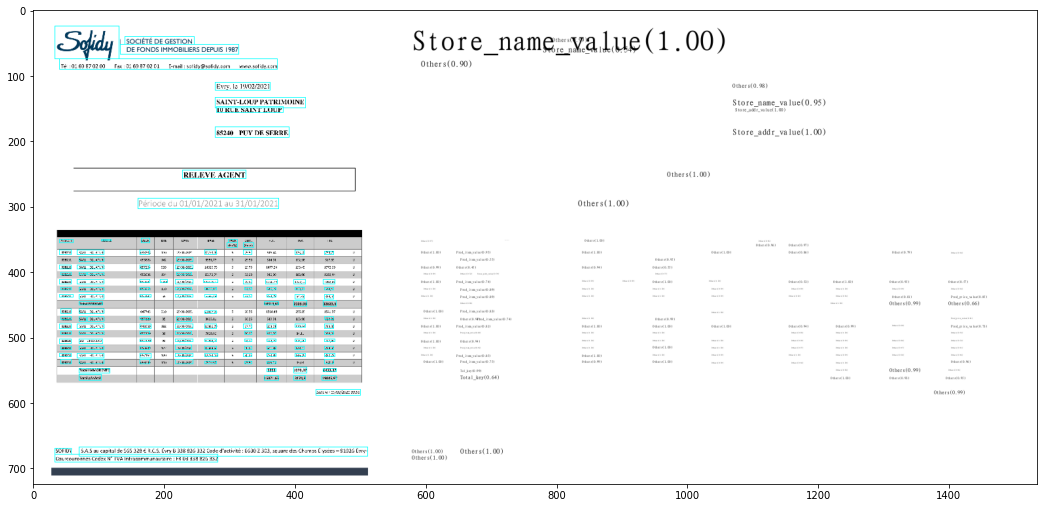

In [9]:
# Visualize the results
import matplotlib.pyplot as plt
predicted_img = mmcv.imread('demo/out004.png')
plt.figure(figsize=(18, 32))
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()

<IPython.core.display.Javascript object>


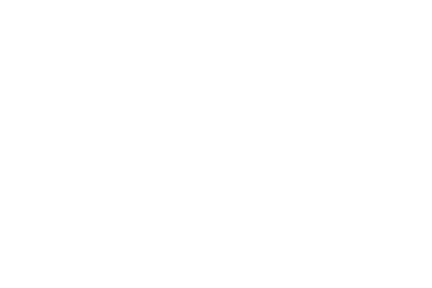

In [10]:
from sklearn.cluster import KMeans
import numpy as np
import math
import itertools

from matplotlib import pyplot as plt
%matplotlib notebook

X = np.array([[x['x']] for x in results])
ax = []
ay = []

overlapList = []
ax = []

for c in range(2, len(results)//2):
    kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    centers = [i[0] for i in kmeans.cluster_centers_]
    
    labels = kmeans.labels_
    
    overlap = 0
    
    #Find overlaping element in clusters based on xmin and xmax
    for idx, i in enumerate(centers):
        for jdx, j in enumerate(results):
            if labels[jdx] != idx:
                if i >= j['xmin'] and i <= j['xmax']:
                    overlap += 1
        
    overlapList.append(overlap)
    ax.append(c)


    
    
    
ax = np.array(ax)
ay = np.array(overlapList)

plt.plot(ax, ay)

In [11]:
def getError(reg, x, y):
    x = [i[0] for i in x]
    y = [i[0] for i in y]
    a = reg.coef_
    b = reg.intercept_
    rv = 0
    for idx, i in enumerate(x):
        rv += (a*i + b - y[idx])**2
    return rv    

In [12]:
from sklearn.linear_model import LinearRegression
X = [[n] for n in range(len(ay))]
y = [[n] for n in ay]
maxScore = 0
xClusters = 0

for n in range(2, len(ay)-2):
    X1 = X[:n]
    y1 = y[:n]
    X2 = X[n:]
    y2 = X[n:]
    reg1 = LinearRegression().fit(X1, y1)
    reg2 = LinearRegression().fit(X2, y2)
    res = getError(reg1, X1, y1)[0][0] + getError(reg2, X2, y2)[0][0]
    if res > 10:
        xClusters = n-1
        break
        
print(xClusters)

8


<IPython.core.display.Javascript object>


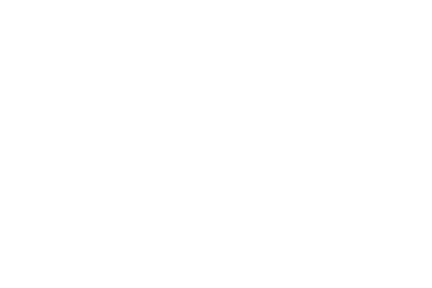

In [13]:
%matplotlib notebook

from sklearn.cluster import KMeans
import numpy as np
import math
import itertools

from matplotlib import pyplot as plt
%matplotlib notebook

X = np.array([[y['y']] for y in results])
ax = []
ay = []

overlapList = []
ax = []

for c in range(2, len(results)//2):
    kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    centers = [i[0] for i in kmeans.cluster_centers_]
    
    labels = kmeans.labels_
    
    overlap = 0
    
    #Find overlaping element in clusters based on ymin and ymax
    for idx, i in enumerate(centers):
        for jdx, j in enumerate(results):
            if labels[jdx] != idx:
                if i >= j['ymin'] and i <= j['ymax']:
                    overlap += 1
        
    overlapList.append(overlap)
    ax.append(c)
    
    
ax = np.array(ax)
ay = np.array(overlapList)

plt.plot(ax, ay)

In [14]:
from sklearn.linear_model import LinearRegression
X = [[n] for n in range(len(ay))]
y = [[n] for n in ay]
maxScore = 0
yClusters = 0
for n in range(2, len(ay)-2):
    X1 = X[:n]
    y1 = y[:n]
    X2 = X[n:]
    y2 = X[n:]
    reg1 = LinearRegression().fit(X1, y1)
    reg2 = LinearRegression().fit(X2, y2)
    res = getError(reg1, X1, y1)[0][0] + getError(reg2, X2, y2)[0][0]
    if res > 10:
        yClusters = n-1
        break
        
print(yClusters)

31


In [15]:
X = np.array([[y['y']] for y in results])

kmeans = KMeans(n_clusters=yClusters, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]

newOrder = [{'class':idx, 'coordinate':i} for idx, i in enumerate(centers)]
newOrder.sort(key=lambda x:x['coordinate'])
yClassMapping = {i['class']: idx for idx, i in enumerate(newOrder)}

for idx, i in enumerate(kmeans.labels_):
    results[idx]['yClass'] = i

In [16]:
X = np.array([[x['x']] for x in results])

kmeans = KMeans(n_clusters=xClusters, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]

newOrder = [{'class':idx, 'coordinate':i} for idx, i in enumerate(centers)]
newOrder.sort(key=lambda x:x['coordinate'])
xClassMapping = {i['class']: idx for idx, i in enumerate(newOrder)}

labels = kmeans.labels_

for idx, i in enumerate(kmeans.labels_):
    results[idx]['xClass'] = i

In [17]:
array = [[-1 for _ in range(xClusters)] for _ in range(yClusters)]
for idx, i in enumerate(results):
    array[yClassMapping[i['yClass']]][xClassMapping[i['xClass']]] = idx 
    
    
for i in array:
    print(i)
    
for i in array:
    print([results[a]['text'].replace('\n', '') if a > -1 else ''  for a in i])

[0, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1]
[2, 3, 4, 5, 6, 7, 8, 9]
[10, -1, 17, 12, 13, 14, 18, 16]
[-1, -1, -1, -1, -1, -1, 19, -1]
[21, 22, 23, 24, 25, 26, 27, 28]
[-1, -1, -1, -1, 30, -1, -1, -1]
[31, 32, 33, 34, 38, 36, -1, 37]
[40, 41, 42, 43, 44, 45, 46, 47]
[-1, -1, -1, -1, 49, -1, -1, -1]
[50, 51, 52, 53, 54, 55, 56, -1]
[-1, -1, -1, -1, 58, -1, -1, -1]
[59, 60, 61, 62, 63, 64, 65, 66]
[-1, -1, -1, -1, 68, -1, -1, -1]
[72, -1, -1, -1, -1, -1, 69, 71]
[73, 74, 75, 76, 77, 78, -1, 79]
[-1, -1, -1, -1, 81, -1, -1, -1]
[82, 83, 84, 85, 86, 87, -1, 88]
[-1, 89, -1, -1, 90, -1, -1, -1]
[92, 93, 94, 95, 96, 97, 98, 99]
[-1, 100, -1, -1, 101, -1, -1, -1]
[103, 104, 105, 106, 107, 108, 109, 110]
[-1, 111, -1, -1, 113, -1, -1, -1]
[114, -1, -1, -1, -1, -1, 115, 116]
[124, 118, 119, 120, 121, 122, 125, 126]
[-1, 128, -1, -1, 129, -1, -1, -1]
[130, 131, 132, 133, 134, 135, 136, 137]
[-1, 138, -1, -1, 139, -1, -1, 123]
[141, 142, 143, 144, 145, 146, 147, -1]
[-1, 148, 

In [18]:
def findNextLine(start, arr):
    width = len(arr[0])
    widthTrigger = round(width * lineFactor)
    firstLine = 0
    for i in range(start, len(arr)):
        a = 0
        for j in arr[i]:
            if j != -1:
                a += 1
        if a >= widthTrigger:
            return i
    return -1

firstLine = findNextLine(0, array)

In [19]:
index = firstLine
toMerge = []

while index < len(array):
    nextLine = findNextLine(index, array)
    if nextLine == -1:
        break
    elif nextLine != index:
        toMerge.append((index - 1, nextLine))
        index = nextLine
    else:
        index += 1
        
print(toMerge)    

[(3, 5), (5, 7), (8, 10), (10, 12), (12, 15), (15, 17), (17, 19), (19, 21), (21, 24), (24, 26), (26, 28)]


In [20]:
merged = []

def fusion(rv, line):
    for idx, i in enumerate(rv):
        if line[idx] != -1:
            rv[idx].append(line[idx])
    return rv

for m in toMerge:
    t = []
    for idx in range(m[0], m[1]):
        if idx == m[0]:
            t = [[a] for a in array[idx]]
        else:
            fusion(t, array[idx])
    merged.append(t)
    
for i in merged:
    print(i)

[[10], [-1], [17], [12], [13], [14], [18, 19], [16]]
[[21], [22], [23], [24], [25, 30], [26], [27], [28]]
[[40], [41], [42], [43], [44, 49], [45], [46], [47]]
[[50], [51], [52], [53], [54, 58], [55], [56], [-1]]
[[59, 72], [60], [61], [62], [63, 68], [64], [65, 69], [66, 71]]
[[73], [74], [75], [76], [77, 81], [78], [-1], [79]]
[[82], [83, 89], [84], [85], [86, 90], [87], [-1], [88]]
[[92], [93, 100], [94], [95], [96, 101], [97], [98], [99]]
[[103, 114], [104, 111], [105], [106], [107, 113], [108], [109, 115], [110, 116]]
[[124], [118, 128], [119], [120], [121, 129], [122], [125], [126]]
[[130], [131, 138], [132], [133], [134, 139], [135], [136], [137, 123]]


In [21]:
import pandas as pd
from IPython.display import display, HTML

array = [['' for _ in range(xClusters)] for _ in range(yClusters)] 
for idx, i in enumerate(merged):
    for jdx, j in enumerate(i):
        text = ' '.join([results[k]['text'].replace('\n', '') if k > -1 else '' for k in j])
        array[idx][jdx] = text

pdResult = pd.DataFrame(array)

display(HTML(pdResult.to_html()))

pdResult.to_csv('test1.csv')

,0,1,2,3,4,5,6,7
0,Contrat,,opération,échéance,commission,commission,Commission (Annulation de,Commission
1,53023457,COURTIN Cyril,01/01/2021,31/03/2021,COMM. SUR GESTION,"70 894,20","0,00","201,10"
2,53023457,COURTIN Cyril,01/07/2019,30/09/2019,COMM. SUR GESTION,"14 972,00",0.00,"24,87"
3,53023457,COURTIN Cyril,01/10/2019,31/12/2019,COMM. SUR GESTION,15 479.50,9.66,
4,53023457 8301 - HIMALIA,COURTIN Cyril,01/10/2019,31/12/2019,COMM. SUR GESTION,"15 479,50","0,00 19 02",25.67 254 64
5,83211679,ROBIN Philippe,01/01/2021,31/03/2021,COMM. SUR GESTION,13 706.64,,37.09
6,83417029,DE FONTENAY Emmanuel,01/01/2021,31/03/2021,COMM. SUR rRAIS VDE,"27 123,28",,"46,95"
7,83515704,STEINBERGER Emma,01/01/2021,31/03/2021,COMM. SUR rRAIS DE,"9 606,37","0,00","28,51"
8,83515705 Sous Total 8301 - HIMALIA,STEINBERGER Mathie,01/01/2021,31/03/2021,COMM. SUR GESTION,9 603.85,0.00 0.00,28.51 141.06
9,83020019,BOULET FranCois,01/01/2021,31/03/2021,COMM. SUR GESTION,"20 657,93",0.00,58.02


In [22]:
'''X = np.array([[x['x']] for x in results])
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    
'''

"X = np.array([[x['x']] for x in results])\nSum_of_squared_distances = []\nK = range(1,15)\nfor k in K:\n    kmeans = KMeans(n_clusters=k)\n    kmeans = kmeans.fit(X)\n    Sum_of_squared_distances.append(kmeans.inertia_)\nplt.plot(K, Sum_of_squared_distances, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Sum_of_squared_distances')\nplt.title('Elbow Method For Optimal k')\nplt.show()    \n"

In [23]:
calval = 30

kmeans = KMeans(n_clusters=calval, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]
    
labels = kmeans.labels_

calc = {yc:0 for yc in range(max(labels)+1)}
for i in labels:
    calc[i] += 1

toRemove = []
for key in calc:
    if calc[key] < calval:
        toRemove.append(key)

newResults = [] 
for idx, i in  enumerate(results):
    if not labels[idx] in toRemove:
        newResults.append(i)

In [24]:
X = np.array([[x['x']] for x in results])
kmeans = KMeans(n_clusters=xClusters, random_state=42).fit(X)
xPred = kmeans.labels_
xs = [i[0] for i in kmeans.cluster_centers_]


X = np.array([[y['y']] for y in results])
kmeans = KMeans(n_clusters=yClusters, random_state=42).fit(X)
yPred = kmeans.labels_
ys = [i[0] for i in kmeans.cluster_centers_]

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


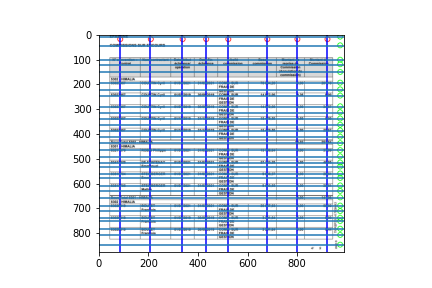

In [25]:
%matplotlib 
import cv2
from matplotlib import pyplot as plt
image = cv2.imread(img) 
for x in xs: 
    cv2.circle(image, (round(x), 20), 10, (0,0,255), 2)
     
    plt.vlines(x, 0, 1500, colors='blue', linestyles='solid', label='', data=None)

x = len(image[0])-20
for y in ys: 
    cv2.circle(image, (x, round(y)), 10, (0,255,0), 2)
    
    plt.hlines(y, 0, 2500, colors=None, linestyles='solid', label='', data=None, )
#plt.savefig("test.png", format="png")    
plt.imshow(mmcv.bgr2rgb(image))
#cv2.imwrite('demo/out.png', mmcv.bgr2rgb(image))


In [26]:
#print(results)    

In [27]:
for idx, i in enumerate(results):
    print(f"({xPred[idx]}, {yPred[idx]}) => {i['text']}")

(4, 22) => EPARGNE

(1, 14) => COMMISSIONS SUR ENCOURS

(4, 6) => N° convention —

(1, 6) => Nom contractant

(5, 6) => Date début

(7, 6) => Date Fin

(0, 6) => Libellé

(3, 6) => Base

(6, 6) => Montant de

(2, 6) => Montant de

(4, 19) => Contrat

(5, 19) => echeance/

(7, 19) => échéance

(0, 19) => commission

(3, 19) => commission

(6, 19) => reprise de

(2, 19) => Commission

(5, 19) => opération

(6, 19) => Commission

(6, 1) => (Annulation de

(4, 11) => 5302 - HIMALIA

(4, 11) => 53023457

(1, 11) => COURTIN Cyril

(5, 11) => 01/01/2021

(7, 11) => 31/03/2021

(0, 11) => COMM. SUR

(3, 11) => 70 894,20

(6, 11) => 0,00

(2, 11) => 201,10

(0, 26) => rRAIS DE

(0, 26) => GESTION

(4, 5) => 53023457

(1, 5) => COURTIN Cyril

(5, 5) => 01/07/2019

(7, 5) => 30/09/2019

(0, 5) => COMM. SUR

(3, 5) => 14 972,00

(2, 5) => 0,00

(0, 5) => FRAIS DE

(0, 13) => GESTION

(4, 13) => 53023457

(1, 13) => COURTIN Cyril

(5, 13) => 01/07/2019

(7, 13) => 30/09/2019

(0, 13) => COMM. SUR



In [28]:
import pandas as pd
array = [['' for _ in range(xClusters)] for _ in range(yClusters)] 
for idx, i in enumerate(results):
    array[yPred[idx]][xPred[idx]] = "".join(list(i['text']))

pd.DataFrame(array).to_csv("test.csv")